In [ ]:
%%capture
!pip install fastai==2.4
!pip install pytube

In [ ]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files
from pytube import YouTube

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [ ]:
generator_model_path = "/content/gdrive/MyDrive/pretrained_models/image_colorization/res18-unet.pt"
colorization_model_path = "/content/gdrive/MyDrive/pretrained_models/image_colorization/final_model_weights.pt"
gen_checkpoint_path = "/content/gdrive/My Drive/models/gen_checkpoint_epoch_{epoch}.pt"
color_checkpoint_path = "/content/gdrive/My Drive/models/color_checkpoint_epoch_{epoch}.pt"

In [ ]:
print(os.listdir('/content/gdrive'))
print(os.listdir('/content/gdrive/My Drive/pretrained_models/image_colorization/'))

['.shortcut-targets-by-id', '.file-revisions-by-id', 'MyDrive', '.Trash-0', '.Encrypted']
['res18-unet.pt']


# **PREPARING THE DATASET**

In [ ]:
seed = 123
fit = False
SIZE = 256
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(seed)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

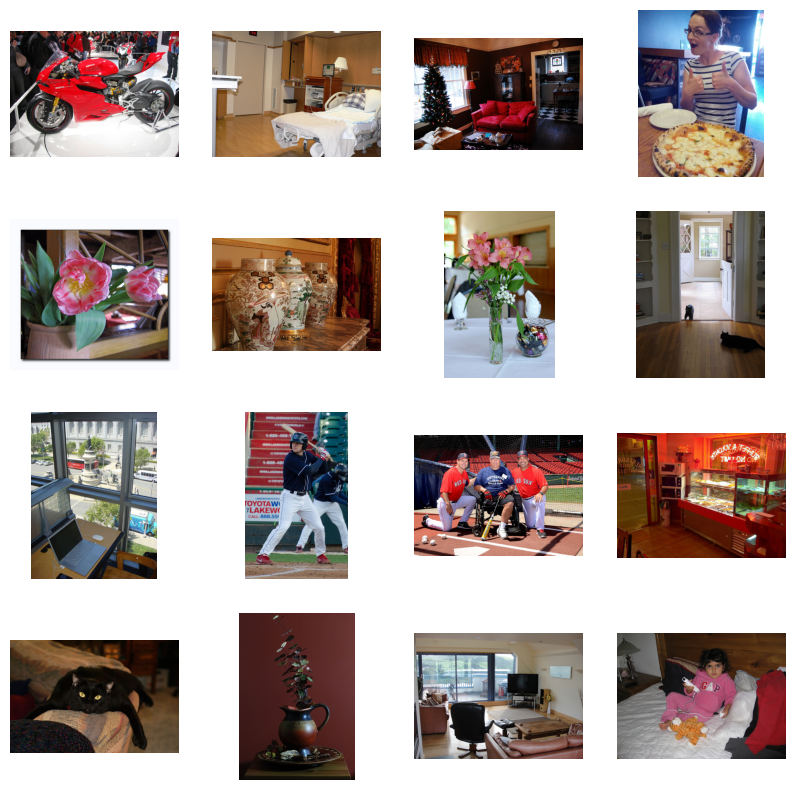

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

#**DATASETS AND DATALOADER**

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

#**Image Colourization Model**
##Feature Generator using U-net

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(pretrained=True), n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

##Creating Checkpoints


In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path.format(epoch=epoch))
    print(f"Checkpoint saved at epoch {epoch}")

# Function to load from checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Resuming from epoch {epoch}")
    return epoch, loss


##Training


In [ ]:

# Checkpoint and training loop with exception handling
try:
    # Initialize model, optimizer, and criterion
    net_G = build_res_unet(n_input=1, n_output=2, size=SIZE)
    opt = optim.Adam(net_G.parameters(), lr=1e-4)
    criterion = nn.L1Loss()

    # Set starting epoch and loss
    start_epoch = 0
    loss = None

    # Optionally load from the latest checkpoint
    try:
        checkpoint_epoch = 17  # For example, specify the latest checkpoint you have
        start_epoch, loss = load_checkpoint(net_G, opt, gen_checkpoint_path.format(epoch=checkpoint_epoch))
    except FileNotFoundError:
        print("No checkpoint found. Starting from scratch.")

    # Training loop
    num_epochs = 20
    for epoch in range(start_epoch, num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        pretrain_generator(net_G, train_dl, opt, criterion, epoch)

        # Save checkpoint every few epochs (e.g., every 5 epochs)
        #if (epoch + 1) % 2 == 0:
        save_checkpoint(net_G, opt, epoch+1, loss, gen_checkpoint_path)

    # Save final model after training
    torch.save(net_G.state_dict(), generator_model_path)
    print(f"Model saved at {generator_model_path}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


Resuming from epoch 17
Starting epoch 18/20


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/17
L1 Loss: 0.06413


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/17
L1 Loss: 0.05881


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/17
L1 Loss: 0.05508


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/17
L1 Loss: 0.05264


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/17
L1 Loss: 0.05056


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/17
L1 Loss: 0.04884


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/17
L1 Loss: 0.04771


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/17
L1 Loss: 0.04676


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/17
L1 Loss: 0.04604


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/17
L1 Loss: 0.04568


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/17
L1 Loss: 0.04538


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/17
L1 Loss: 0.04502


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/17
L1 Loss: 0.04380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/17
L1 Loss: 0.04323


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/17
L1 Loss: 0.04270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/17
L1 Loss: 0.04217


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/17
L1 Loss: 0.04179
Checkpoint saved at epoch 18
Starting epoch 19/20


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

##GAN Colourization Model

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            #if i % display_every == 0:
                #print(f"\nEpoch {e+1}/{epochs}")
                #print(f"Iteration {i}/{len(train_dl)}")
                #log_results(loss_meter_dict) # function to print out the losses
                #visualize(model, data, save=False) # function displaying the model's outputs

In [ ]:
try:
    # Initialize model, optimizer, and criterion
    net_G = build_res_unet(n_input=1, n_output=2, size=256)
    net_G.load_state_dict(torch.load(generator_model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    model = MainModel(net_G=net_G)
    opt = optim.Adam(net_G.parameters(), lr=1e-4)
    criterion = nn.L1Loss()

    # Set starting epoch and loss
    start_epoch = 0
    loss = None

    # Optionally load from the latest checkpoint
    try:
        checkpoint_epoch = 19  # For example, specify the latest checkpoint you have
        start_epoch, loss = load_checkpoint(model, opt, color_checkpoint_path.format(epoch=checkpoint_epoch))
    except FileNotFoundError:
        print("No checkpoint found. Starting from scratch.")

    # Training loop
    num_epochs = 20
    for epoch in range(start_epoch, num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        train_model(model, train_dl, epoch)

        # Save checkpoint every few epochs (e.g., every 5 epochs)
        #if (epoch + 1) % 5 == 0:
        save_checkpoint(model, opt, epoch+1, loss, color_checkpoint_path)

    # Save final model after training
    torch.save(net_G.state_dict(), colorization_model_path)
    print(f"Model saved at {colorization_model_path}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

model initialized with norm initialization
Resuming from epoch 19
Starting epoch 20/20


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Checkpoint saved at epoch 20
Model saved at /content/gdrive/MyDrive/pretrained_models/image_colorization/final_model_weights.pt


In [ ]:
print(os.listdir('/content/gdrive/My Drive/pretrained_models/image_colorization/'))

['res18-unet.pt', 'final_model_weights.pt']


model initialized with norm initialization


Saving test_image_2.jpg to test_image_2.jpg


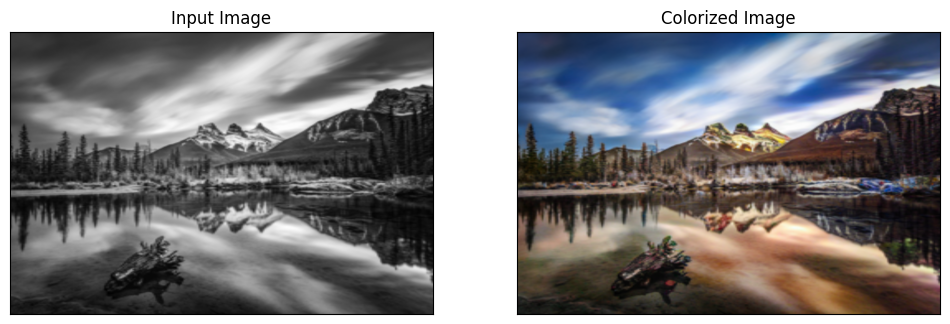

In [ ]:
#@title Select the input type - Image or Video


data = "Image" #@param ["Image", "Video"]

# Load pretrained models
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(generator_model_path, map_location=device))
model = MainModel(net_G=net_G)
net_G.load_state_dict(torch.load(colorization_model_path, map_location=device))
# Model load complete!

def visualize(save=True, **images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if save:
        plt.savefig(f"output.png")
    plt.show()


def load_video(input_loc):
    frames = []
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Frame num: ", video_length)
    count = 0
    print ("Extracting frames..\n")
    while cap.isOpened():
        ret, frame = cap.read()
        data, shape = prep_data(img=Image.fromarray(frame))
        fake_imgs, real_imgs = predict(model, data)
        frame = cv2.resize(fake_imgs[0], shape)
        frame = cv2.resize(frame, None, fx=0.4, fy=0.4)
        frames.append(frame)
        count = count + 1
        if (count > (video_length-1)):
            cap.release()
            print ("Completed.\n%d frame extracted." % count)
            break
    return frames

def prep_data(path=None, img=None):
    _transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
    if path is not None:
        img = Image.open(path).convert("RGB")
    shape = img.shape[:2]
    img = _transforms(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
    ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

    return {'L': L[None, :], 'ab': ab[None, :]}, (shape[1], shape[0])

def predict(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    return fake_imgs, real_imgs

if data == 'Video':
    gif_path = '/content/output.gif'
    video = YouTube(input('URL : '))
    downloaded_path = video.streams.get_highest_resolution().download()
    print('Video is downloaded!')
    frames = load_video(downloaded_path)
    imageio.mimsave(gif_path, frames, format='GIF')
else:
    uploaded_path = files.upload()
    uploaded_path = list(uploaded_path.keys())[0]
    uploaded_path = os.path.join('/content/', uploaded_path)
    data, shape = prep_data(path=uploaded_path)
    fake_imgs, real_imgs = predict(model, data)
    input_im = cv2.resize(real_imgs[0], shape)
    output = cv2.resize(fake_imgs[0], shape)
    visualize(
        input_image = input_im,
        colorized_image = output
    )